## Time Series in Python Using Darts Library
#Predicción del consumo de gas natural

1.   Adecuar dataframe en una serie temporal  
2.   Escalar la serie
3.   Dividir la serie para entrenamiento y validación usando slicing

## Aprendizaje profundo con N-BEATS 
4.   Adaptamos el modelo a la serie  
5.   Pronostico los días restantes  
6.   Ploteo el resultado  

## Exponential smoothing 
Este método es adecuado para pronosticar datos sin una tendencia clara o un patrón estacional.
7. Entreno el modelo exponential smoothing en la serie
8. Realizo la predición
8. Ploteo el resultado




In [ ]:
!pip install pyyaml==5.4.1

In [ ]:
!pip install darts

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
from darts import TimeSeries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file="https://raw.githubusercontent.com/nestorvqz/ecodata/main/SudoesteToledo2022.csv"

In [ ]:
# Leo el archivo
df_1 = pd.read_csv(file, encoding='latin-1', delimiter =';')

In [ ]:
# Paso una funcion para eliminar el punto en A.M./P.M.
df_1["DateTime"] = df_1["DateTime"].apply(lambda x: x.replace(".",""))

In [ ]:
#Convierto a un formatoe datetime
df_1["DateTime"] = pd.to_datetime(df_1.DateTime,format='%d/%m/%Y %I:%M:%S %p')

In [ ]:
# Convierte¿o el tiempo en indice
df_1.index=df_1['DateTime']

In [ ]:
# selecciono Sólo sudoeste
mask = df_1.loc[:, 'StationName'] == 'Sudoeste'
df_2 = df_1.loc[mask]

In [ ]:
# calculo la media cada hora
df_2=df_2.resample('1d').mean()

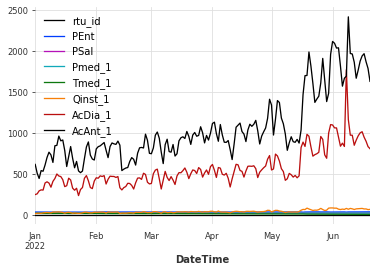

In [ ]:
df_2.plot()

In [ ]:
# genero la columna con el dato del resample
df_2['timestamp']=df_2.index

In [ ]:
df_2.head(1)

,rtu_id,PEnt,PSal,Pmed_1,Tmed_1,Qinst_1,AcDia_1,AcAnt_1,timestamp
DateTime,,,,,,,,,
2022-01-01,7.0,38.908,25.293,25.293,18.841,10.494,532.211,702.031,2022-01-01


In [ ]:
# TimeSerieses la clase principal en dardos . Representa una serie temporal univariante o multivariante, determinista o estocástica. 
# Los valores se almacenan en una matriz de forma (tiempo, dimensiones, muestras) , donde las dimensiones son las dimensiones (o "componentes" o "columnas") de series multivariadas, y las muestras son muestras de series estocásticas.
# Definiciones:
#   Una serie con dimensiones = 1 es univariante y una serie con dimensiones > 1 es multivariante .
#   Una serie con muestras = 1 es determinista y una serie con muestras > 1 es estocástico (o probabilístico ).
ts_2=TimeSeries.from_dataframe(df_2, time_col='timestamp', value_cols='AcDia_1',fill_missing_dates=True, freq='d')

In [ ]:
ts_2,aa=ts_2.split_before(pd.Timestamp("20220201"))

In [ ]:
df_1['Tmed_1'].plot()

In [ ]:
df_2['Qinst_1'].plot()

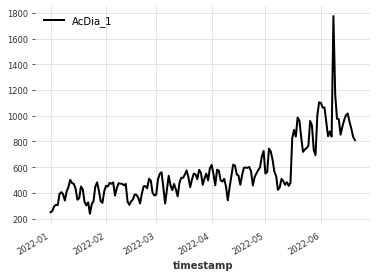

In [ ]:
ts_2.plot()

In [ ]:
es_sudoeste = df_1.loc[:, 'StationName'] == 'Sudoeste'
es_toledo = df_1.loc[:, 'StationName'] == 'Toledo'
es_vabower = df_1.loc[:, 'StationName'] == 'Vál. Aut. Bower'

In [ ]:
df_sudoeste = df_1.loc[es_sudoeste]
df_toledo = df_1.loc[es_toledo]
df_vabower = df_1.loc[es_vabower]
df_toledo.describe()

In [ ]:
sns.lineplot(x=df_sudoeste.DateTime, y=df_sudoeste.PEnt)

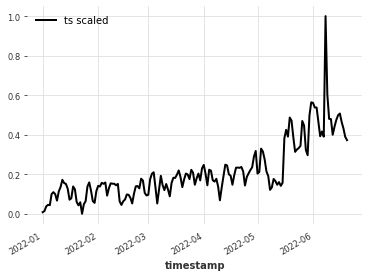

In [ ]:
# escalar la serie entre 0 y 1 para beneficiar los modelos de ML
from darts.dataprocessing.transformers import Scaler
scaler_sudoeste, scaler_milk = Scaler(), Scaler()
ts_2_scaled = scaler_sudoeste.fit_transform(ts_2)


ts_2_scaled.plot(label='ts scaled')

plt.legend();

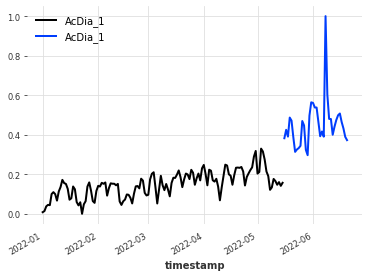

In [ ]:
# Train And Validation Split, using slicing:
train_ts_2, val_ts_2 = ts_2_scaled[:-36], ts_2_scaled[-36:]
#train_ts_2, val_ts_2  = ts_2.split_before(0.50)
train_ts_2.plot()
val_ts_2.plot()

In [ ]:
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape

In [ ]:
# Uso del aprendizaje profundo con N-BEATS
model_ts_2 = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0)

In [ ]:
# Adaptamos el modelo a la serie
model_ts_2.fit(train_ts_2, verbose=True)

2022-08-05 03:30:23 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 100 samples.
2022-08-05 03:30:23 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-08-05 03:30:23 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-08-05 03:30:23 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-05 03:30:23 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-05 03:30:23 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-08-05 03:30:24 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
--

Training: 0it [00:00, ?it/s]

2022-08-05 03:31:53 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 4it [00:00, ?it/s]

mape.
<function mape at 0x7fcc6fe44e60>
MAPE = 48.69%


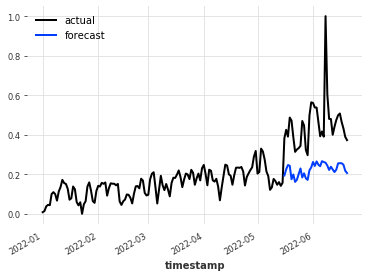

In [ ]:
# Pronéstico para los préoximos 36 días
pred = model_ts_2.predict(n=36, series=train_ts_2)

ts_2_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print("mape.")
print(mape)
print('MAPE = {:.2f}%'.format(mape(ts_2_scaled, pred)))

**Exponential smoothing**
Este método es adecuado para pronosticar datos sin una tendencia clara o un patrón estacional.

In [ ]:
ts_3 = TimeSeries.from_dataframe(df_2, 'timestamp', 'AcDia_1')

In [ ]:
# train an exponential smoothing model on the training series:
from darts.models import ExponentialSmoothing
train, val = ts_3.split_before(pd.Timestamp('20220501'))
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=500)

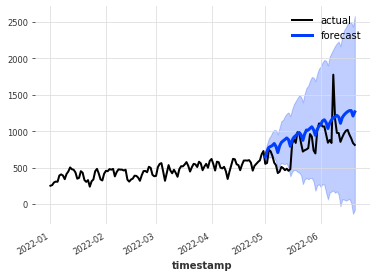

In [ ]:
# By default, if a TimeSeries is probabilistic, Darts will show its 5th and 95th percentiles
# (here the series is probabilistic because we called predict() with num_samples=500).
ts_3.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()